# __Springboard Data Science Capstone 3 Project__
# _Predicting the Price of Energy_

### Pre-Processing & Modeling

##### _Ben Takacs_
###### __Python version 3.10.4__

### __Imports and File Location__

In [341]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import datetime
from functions import load_csv_data, arima_mse, model_eval, sarima_mse, decomposition

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,  mean_squared_error, root_mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import seasonal_decompose


In [359]:
# Plot settings
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


## __Pre-Processing__

### __Load Data__

In [342]:
df = pd.read_csv('./data/df1.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df

,"Average Price of Electricity to Ultimate Customers, Commercial",Total Renewable Energy Consumption,Total Petroleum Consumed by the Commercial Sector,Natural Gas Consumed by the Electric Power Sector,"Natural Gas Consumed by the Transportation Sector, Vehicle Fuel"
Month,,,,,
1990-02-01,7.15,0.321465,89.232,153.181,0.021
1990-03-01,7.23,0.353956,85.491,214.167,0.023
1990-04-01,7.20,0.334136,76.051,231.641,0.022
1990-05-01,7.31,0.317791,73.229,283.776,0.023
1990-06-01,7.49,0.289276,73.648,345.768,0.022
...,...,...,...,...,...
2024-05-01,12.48,0.758321,71.672,1045.631,4.514
2024-06-01,13.07,0.742351,63.796,1243.853,4.368
2024-07-01,13.58,0.733689,60.285,1534.444,4.514


Average price is in units of cents per kilowatt hour, including taxes.\
Renewable energy consumption is in units of quadrillion Btu (10^15)\
Petroleum consumption is in units of trillion Btu (10^12)\
Natural gas consumed is in units of billion cubic feet (10^12)\
Need to convert  energies to same unit.
Also going to rename columsn to something easier.

In [343]:
df.rename(columns={'Average Price of Electricity to Ultimate Customers, Commercial':'Price', 'Total Renewable Energy Consumption':'Renewable', 'Total Petroleum Consumed by the Residential Sector':'Petroleum', 'Natural Gas Consumed by the Electric Power Sector':'Electric', 'Natural Gas Consumed by the Transportation Sector, Vehicle Fuel':'Transportation'}, inplace=True)
df.Renewable *= 1e3
df

,Price,Renewable,Total Petroleum Consumed by the Commercial Sector,Electric,Transportation
Month,,,,,
1990-02-01,7.15,321.465,89.232,153.181,0.021
1990-03-01,7.23,353.956,85.491,214.167,0.023
1990-04-01,7.20,334.136,76.051,231.641,0.022
1990-05-01,7.31,317.791,73.229,283.776,0.023
1990-06-01,7.49,289.276,73.648,345.768,0.022
...,...,...,...,...,...
2024-05-01,12.48,758.321,71.672,1045.631,4.514
2024-06-01,13.07,742.351,63.796,1243.853,4.368
2024-07-01,13.58,733.689,60.285,1534.444,4.514


Renewable and Petroleum now have same units (trillion Btu)

In [344]:
exog = pd.read_csv('./data/exog.csv', index_col=0)
exog.set_index(pd.to_datetime(exog.index), inplace=True)
exog

,Population,GDP
Month,,
1990-02-01,252.273689,10058.925806
1990-03-01,252.500884,10087.247931
1990-04-01,252.728323,10115.630336
1990-05-01,252.956003,10144.072517
1990-06-01,253.183924,10172.573960
...,...,...
2024-05-01,335.258213,23340.273105
2024-06-01,335.309775,23404.211001
2024-07-01,335.359756,23468.810867


##### Don't need to scale data because it's a time series

### __Test Train Split__

In [345]:
# Make differenced dataframe as well for use with modeling
df_diff = pd.DataFrame()
for col in df.columns:
    df_diff[col] = np.diff(df[col])

df_diff.index = df.index[:-1]
df_diff.dropna(inplace=True)
df_diff

,Price,Renewable,Total Petroleum Consumed by the Commercial Sector,Electric,Transportation
Month,,,,,
1990-02-01,0.08,32.491,-3.741,60.986,0.002
1990-03-01,-0.03,-19.820,-9.440,17.474,-0.001
1990-04-01,0.11,-16.345,-2.822,52.135,0.001
1990-05-01,0.18,-28.515,0.419,61.992,-0.001
1990-06-01,0.03,26.596,-1.102,33.816,0.001
...,...,...,...,...,...
2024-04-01,-0.15,21.792,-2.954,163.693,0.146
2024-05-01,0.59,-15.970,-7.876,198.222,-0.146
2024-06-01,0.51,-8.662,-3.511,290.591,0.146


In [346]:
split = 0.8
splitdate = datetime.date(df.index[int(len(df)*split)].year, df.index[int(len(df)*split)].month,1)
splitdateahead = datetime.date(splitdate.year, splitdate.month+1,1)
splitdateback = datetime.date(splitdate.year, splitdate.month-1,1)

print(splitdate)
#Endogenous vars
# normal
train, test = train_test_split(df, train_size=split, shuffle=False)
ytrain = train.Price; ytest = test.Price
xtrain = train.drop(columns='Price'); xtest = test.drop(columns='Price')

# differenced
train_diff, test_diff = train_test_split(df_diff, train_size=split, shuffle=False)
ytrain_diff = train_diff.Price; ytest_diff = test_diff.Price
xtrain_diff = train_diff.drop(columns='Price')
xtest_diff = test_diff.drop(columns='Price')

# Exogenous vars
extrain, extest = train_test_split(exog, train_size=split, shuffle=False)

2017-10-01


In [347]:
print(train.shape, test.shape)
print(extrain.shape, extest.shape)
print(train_diff.shape, test_diff.shape)

(332, 5) (84, 5)
(332, 2) (84, 2)
(332, 5) (83, 5)


### __ARIMA Modeling__

Only takes one variable, price. 

### Eyeball Analysis

From our ACF and PACF analysis in the EDA section, we guessed a good model would be ARIMA of order (1,1,1) or (1,1,2).

In [349]:
model_price_1 = ARIMA(ytrain_diff, order=(1,1,1))
model_price_1_fit = model_price_1.fit()
print(model_price_1_fit.summary())

model_price_2 = ARIMA(ytrain_diff, order=(1,1,2))
model_price_2_fit = model_price_2.fit()
print(model_price_2_fit.summary())

aic_delta = model_price_2_fit.aic - model_price_1_fit.aic
print(aic_delta)

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  332
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  92.627
Date:                Mon, 17 Mar 2025   AIC                           -179.254
Time:                        20:15:56   BIC                           -167.847
Sample:                    02-01-1990   HQIC                          -174.705
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4055      0.065      6.249      0.000       0.278       0.533
ma.L1         -1.0000      8.953     -0.112      0.911     -18.547      16.547
sigma2         0.0330      0.294      0.112      0.9

Model of order (1,1,1) has lower AIC.

### Compare with Auto Arima

In [350]:
# Find best seasonal order using auto_arima
from pmdarima import auto_arima

In [351]:
model_arima_auto = auto_arima(
    y=ytrain_diff, #endogenous stationary data
    m=12,  # monthly frequency
    seasonal=False, # arima
    stationary=True, # data already stationary
)
# Print best model order
print("Best (p, d, q):", model_arima_auto.order)

Best (p, d, q): (3, 0, 5)


In [352]:
forecast_length = 3 * 12 # forecast x years 

model_arima = ARIMA(ytrain, order=model_arima_auto.order, )
model_arima_fit = model_arima.fit()
pred_arima = model_arima_fit.forecast(steps=forecast_length)
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  332
Model:                 ARIMA(3, 0, 5)   Log Likelihood                 178.387
Date:                Mon, 17 Mar 2025   AIC                           -336.774
Time:                        20:16:02   BIC                           -298.723
Sample:                    02-01-1990   HQIC                          -321.599
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1088     31.408      0.290      0.772     -52.450      70.668
ar.L1          2.7304      0.004    721.564      0.000       2.723       2.738
ar.L2         -2.7277      0.007   -382.925      0.0

In [353]:
# Create trend for plotting and comparing
trend = seasonal_decompose(df.Price[:len(ytrain)+forecast_length]).trend

MAE: 0.124
RMSE: 0.151


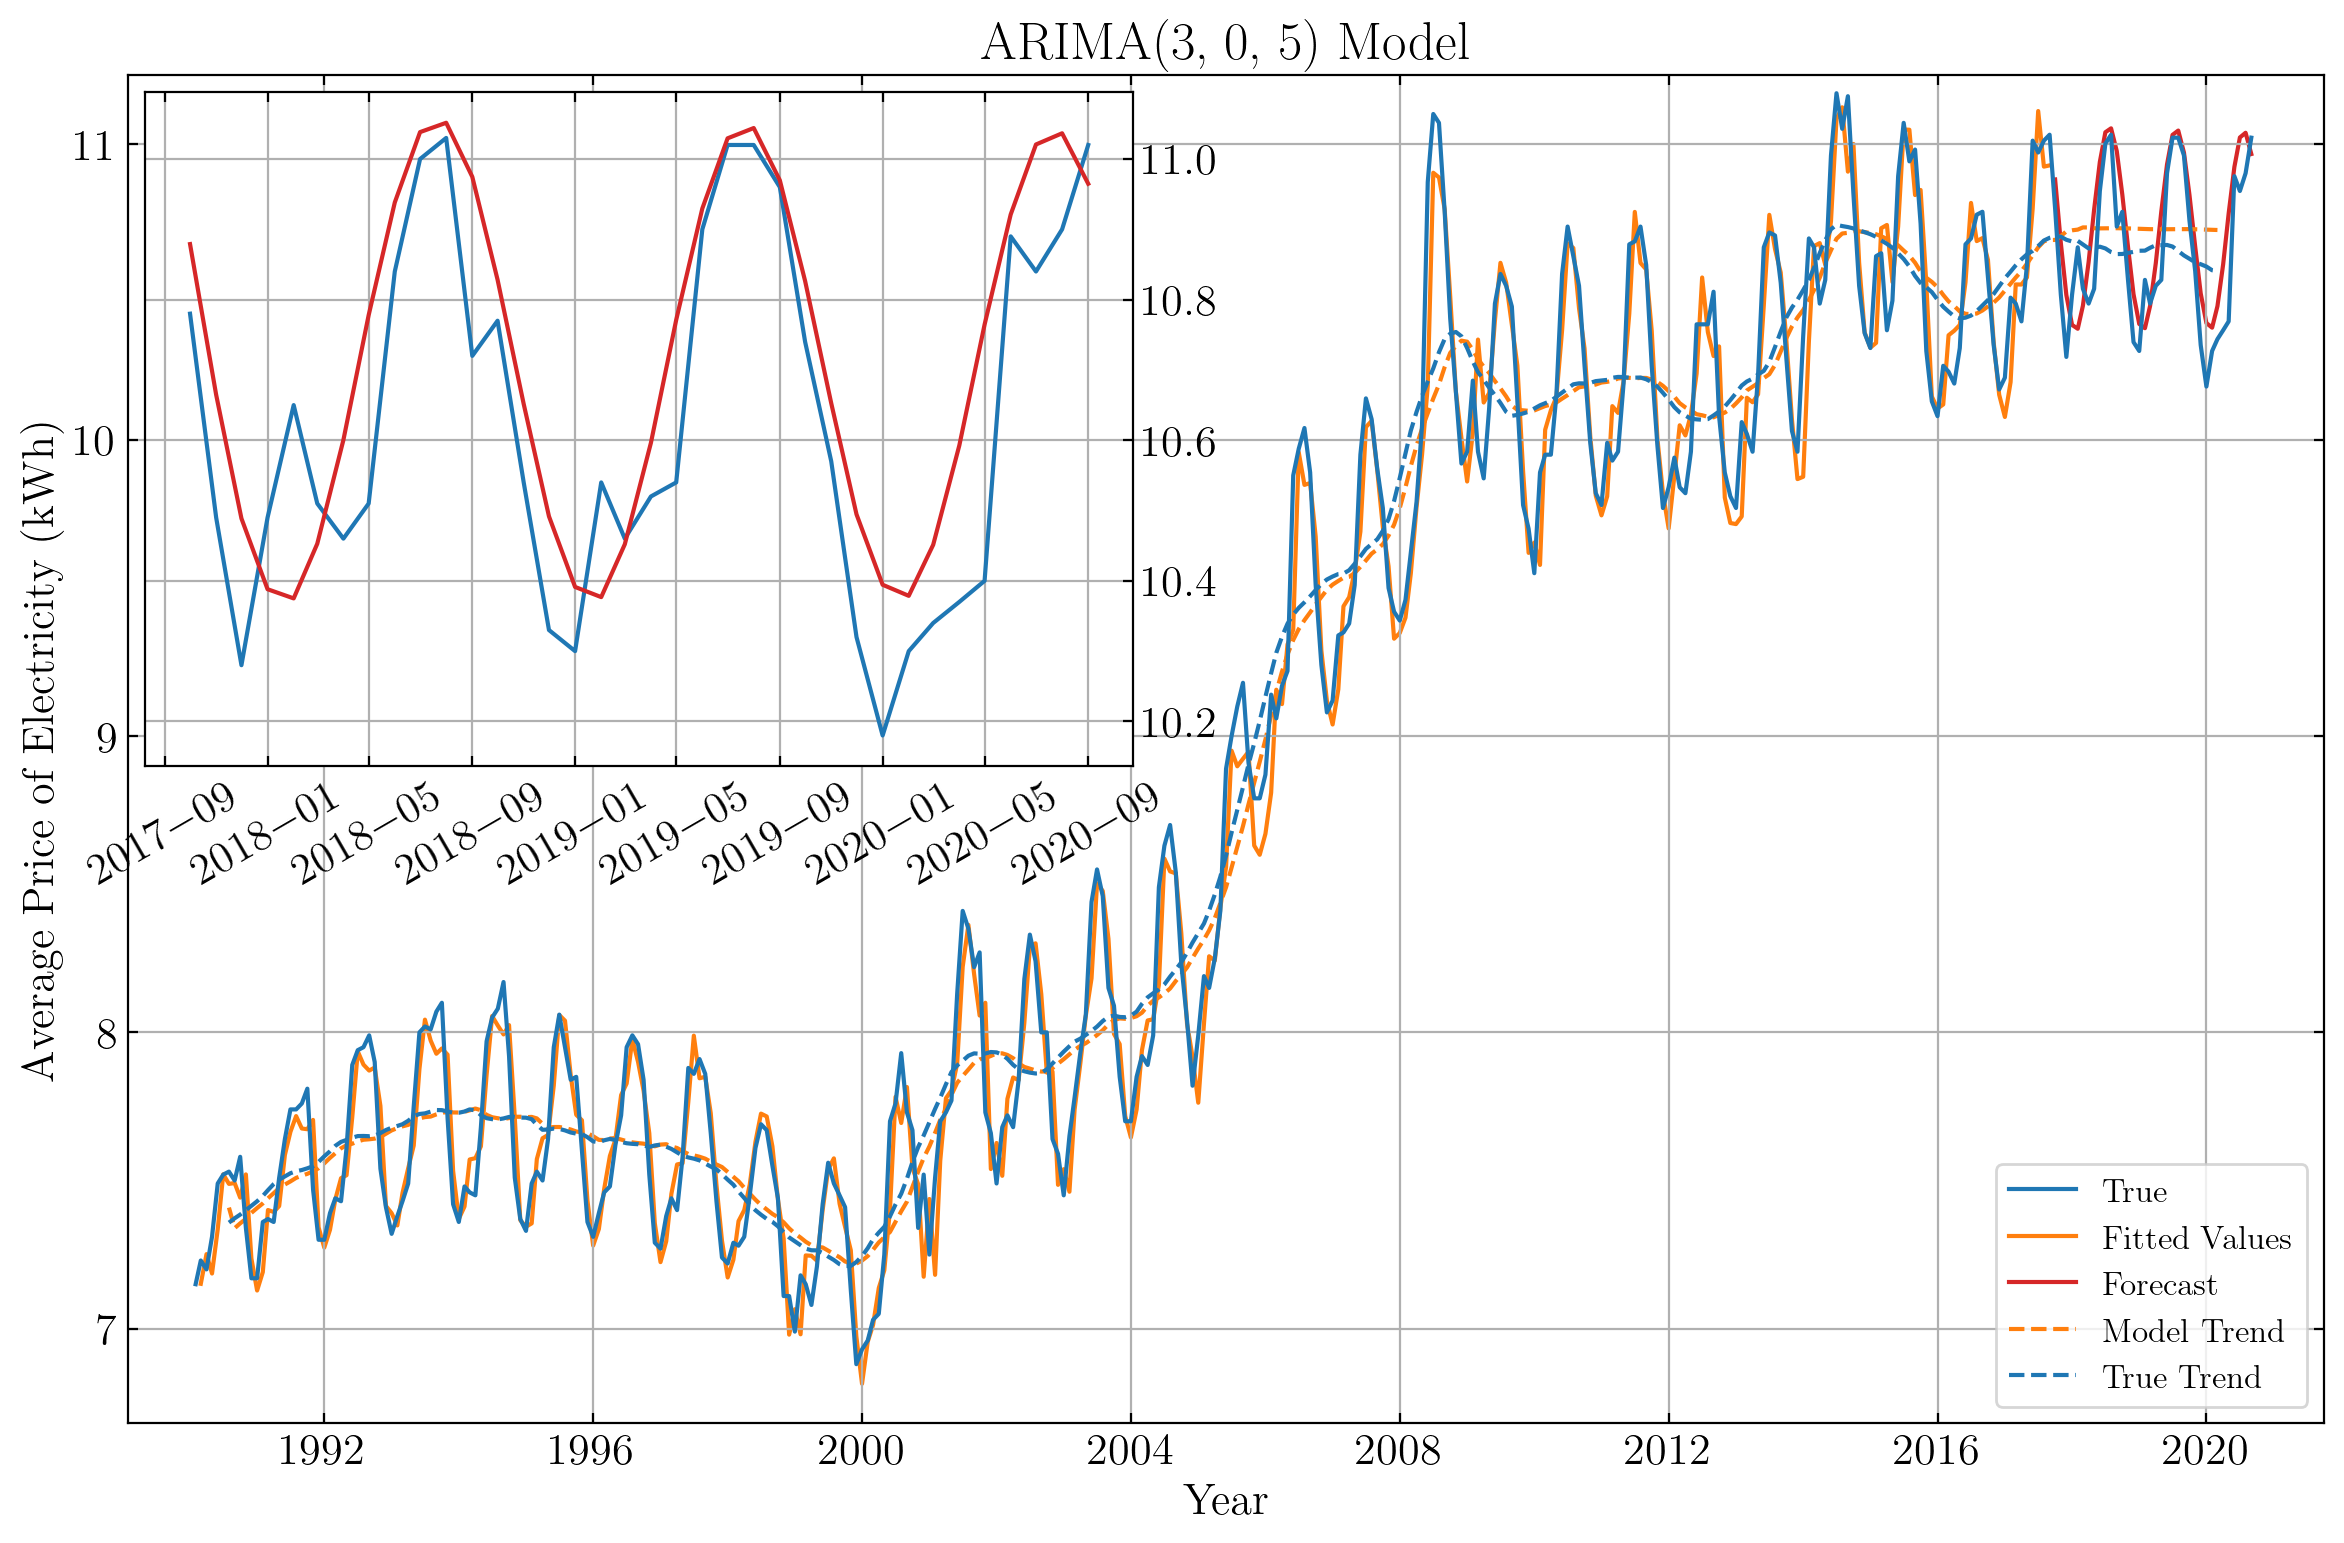

In [365]:
print('MAE: {:.3f}\nRMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], pred_arima),
    root_mean_squared_error(ytest[:forecast_length], pred_arima)
))

# Plot
fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(pd.concat([ytrain, ytest[:forecast_length]]), label='True', c='C0', ls='-', zorder=3)
ax.plot(model_arima_fit.fittedvalues[1:], label='Fitted Values', c='C1', zorder=0)
ax.plot(pred_arima, c='C3', ls='-', label='Forecast', zorder=0)
ax.plot(
    seasonal_decompose(pd.concat([model_arima_fit.fittedvalues, pred_arima])).trend, label='Model Trend', c='C1', ls='--', zorder=0
)
ax.plot(trend, label='True Trend', c='C0', ls='--', zorder=3)
ax.grid(True)
ax.legend(loc='lower right')
inset = inset_axes(ax, width="45%", height="50%", loc=2)
inset.plot(ytest[:forecast_length])
inset.plot(pred_arima, c='C3', ls='-')
inset.grid(visible=True)
inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
inset.set_xticklabels(labels=inset.get_xticklabels(), rotation=30)
ax.set_xlim(
    datetime.date(train.index[0].year-1,train.index[0].month,1),
    datetime.date(test.index[forecast_length].year+1,test.index[forecast_length].month, 1)
)
ax.set_ylim(ytrain.min()-0.2, ytest[:forecast_length].max()+0.2)
ax.set_title('ARIMA{} Model'.format(model_arima_auto.order))
ax.set_ylabel('Average Price of Electricity (kWh)')
ax.set_xlabel('Year')
plt.tight_layout()
plt.savefig('./figures/arima')
plt.show()

### __SARIMAX Model__

SARIMAX can take exogenous variables as well as y.

In [264]:
model_sarima_auto = auto_arima(y=ytrain, #endogenous data,
                               X=extrain, #exogenous data
                               seasonal=True, #SARIMA
                               m=12, # monthly frequency
                               stationary=False
                               )

In [265]:
# Print best model order
print("Best (p, d, q):", model_sarima_auto.order)
print("Best (P, D, Q, s):", model_sarima_auto.seasonal_order)

Best (p, d, q): (0, 1, 0)
Best (P, D, Q, s): (1, 0, 1, 12)


In [266]:
model_sarima_auto1 = SARIMAX(endog=ytrain,
                             exog=extrain,
                             order=model_sarima_auto.order,
                             seasonal_order=model_sarima_auto.seasonal_order,
                             )

model_sarima_auto1_fit = model_sarima_auto1.fit(disp=False)
print(model_sarima_auto1_fit.summary())

pred_sarima_auto1 = model_sarima_auto1_fit.forecast(steps=forecast_length, exog=extest[:forecast_length])

                                      SARIMAX Results                                       
Dep. Variable:                                Price   No. Observations:                  332
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 283.314
Date:                              Mon, 17 Mar 2025   AIC                           -556.628
Time:                                      18:46:58   BIC                           -537.617
Sample:                                  02-01-1990   HQIC                          -549.046
                                       - 09-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Population     0.1416      0.404      0.351      0.726      -0.650       0.933
GDP           -0.00

MAE: 0.069
RMSE: 0.092


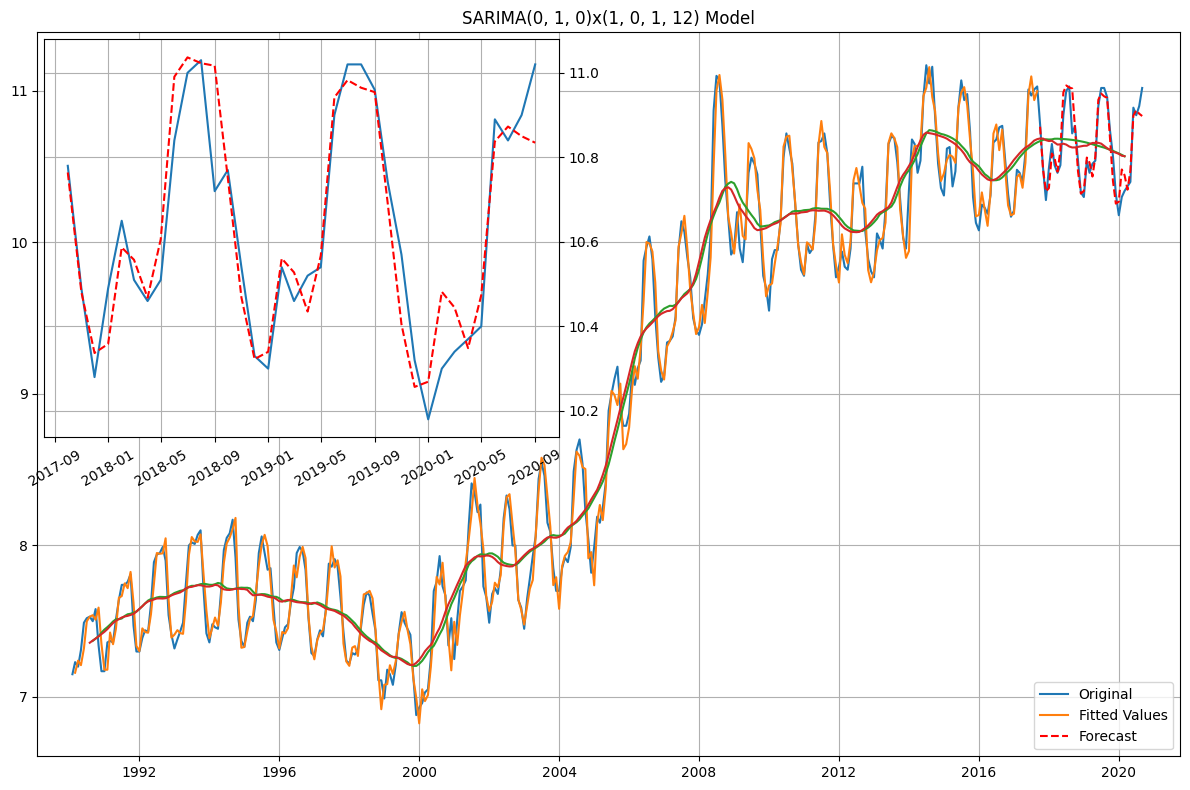

In [339]:
print('MAE: {:.3f}\nRMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], pred_sarima_auto1),
    root_mean_squared_error(ytest[:forecast_length], pred_sarima_auto1)
))

# Plot
fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(pd.concat([ytrain, ytest[:forecast_length]]), label='Original')
ax.plot(model_sarima_auto1_fit.fittedvalues[1:], label='Fitted Values')
ax.plot(pred_sarima_auto1, c='r', ls='--', label='Forecast')
ax.plot(seasonal_decompose(pd.concat([model_sarima_auto1_fit.fittedvalues[1:], pred_sarima_auto1])).trend)
ax.plot(seasonal_decompose(df.Price[:len(ytrain)+forecast_length]).trend)
ax.grid(True)
ax.legend(loc='lower right')
inset = inset_axes(ax, width="45%", height="55%", loc=2)
inset.plot(ytest[:forecast_length])
inset.plot(pred_sarima_auto1, c='r', ls='--')
inset.grid(visible=True)
inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
inset.set_xticklabels(labels=inset.get_xticklabels(), rotation=30)
ax.set_xlim(
    datetime.date(train.index[0].year-1,train.index[0].month,1),
    datetime.date(test.index[forecast_length].year+1,test.index[forecast_length].month, 1)
)
ax.set_title('SARIMA{}x{} Model'.format(
    model_sarima_auto.order, model_sarima_auto.seasonal_order
))
plt.tight_layout()
plt.savefig('./figures/sarima1')
plt.show()

### __VAR Model__

In [272]:
temp_mod = VAR(train)
lag_order = temp_mod.select_order(maxlags=15)
print(lag_order.summary())

best_lag = lag_order.aic
print('Optimal lag order: ', best_lag)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        21.63       21.69   2.481e+09       21.66
1        11.27       11.63   7.853e+04       11.41
2        9.148       9.800       9395.       9.408
3        8.598       9.547       5423.       8.977
4        8.181      9.426*       3576.       8.678
5        7.966       9.507       2886.       8.581
6        7.831       9.669       2525.       8.565
7        7.676       9.811       2167.       8.529
8        7.538       9.969       1892.       8.509
9        7.376       10.10       1614.       8.466
10       7.144       10.17       1284.       8.352
11       7.052       10.37       1177.       8.378
12       6.668       10.28       805.9       8.112
13      6.369*       10.28      601.7*      7.932*
14       6.376       10.59       610.7       8.057
15       6.379       10.88       618.0       8.179
-------------------------------

In [273]:
model_var = VAR(endog=train, exog=extrain, dates=train.index)
model_var_fit = model_var.fit(best_lag)
print(model_var_fit.summary())

forecast_var = model_var_fit.forecast(y=train.values[-best_lag:], steps=forecast_length, exog_future=extest[:forecast_length])

forecast_var = pd.DataFrame(forecast_var)
forecast_var.columns = train.columns
forecast_var.index = test.index[:len(forecast_var)]

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 17, Mar, 2025
Time:                     18:50:03
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    10.2964
Nobs:                     319.000    HQIC:                   7.88599
Log likelihood:          -2925.40    FPE:                    553.646
AIC:                      6.28333    Det(Omega_mle):         210.684
--------------------------------------------------------------------
Results for equation Price
                                                           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------------------------
const                                                       -11.081912         5.042168           -2.198           0.028
Population           

This model sees much less correlation between Price and the other features, perhaps due to differencing.

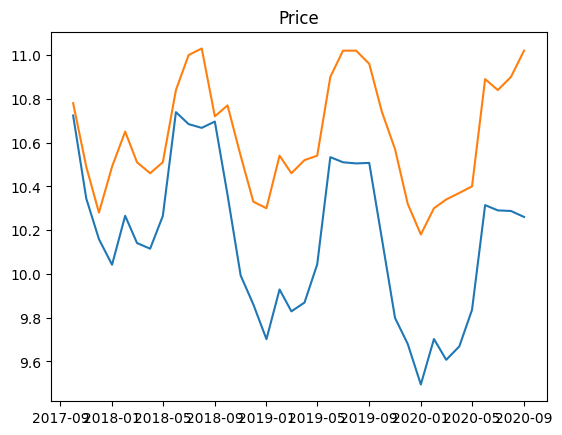

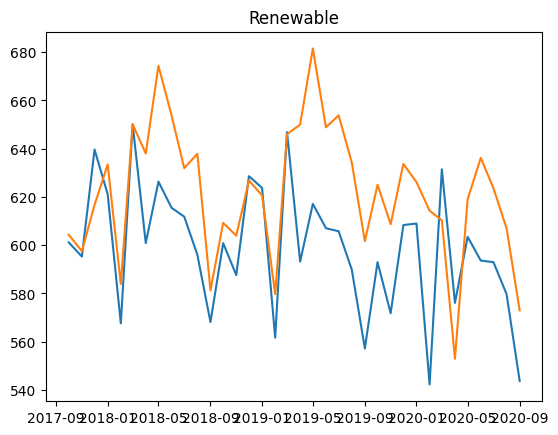

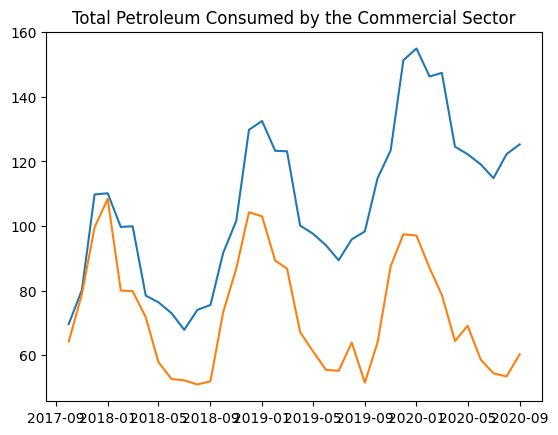

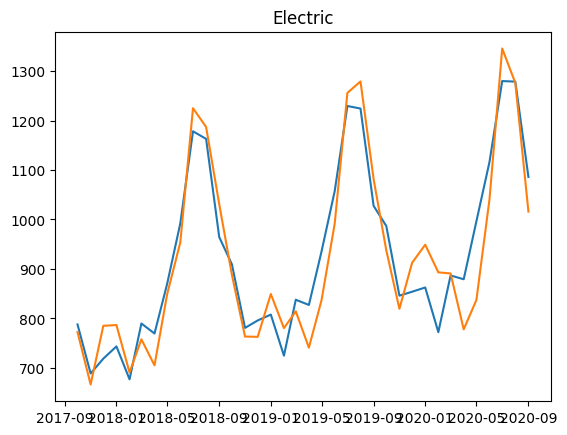

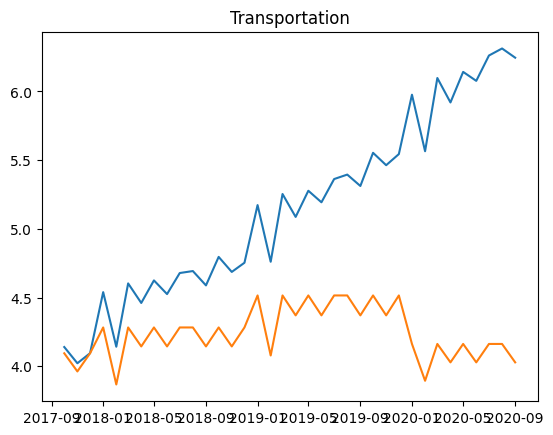

In [274]:
for col in forecast_var:
    plt.figure()
    plt.title(col)
    plt.plot(forecast_var[col], label='Prediction')
    plt.plot(test[col][:len(forecast_var)])
    plt.show()

MAE: 0.471
RMSE: 0.511


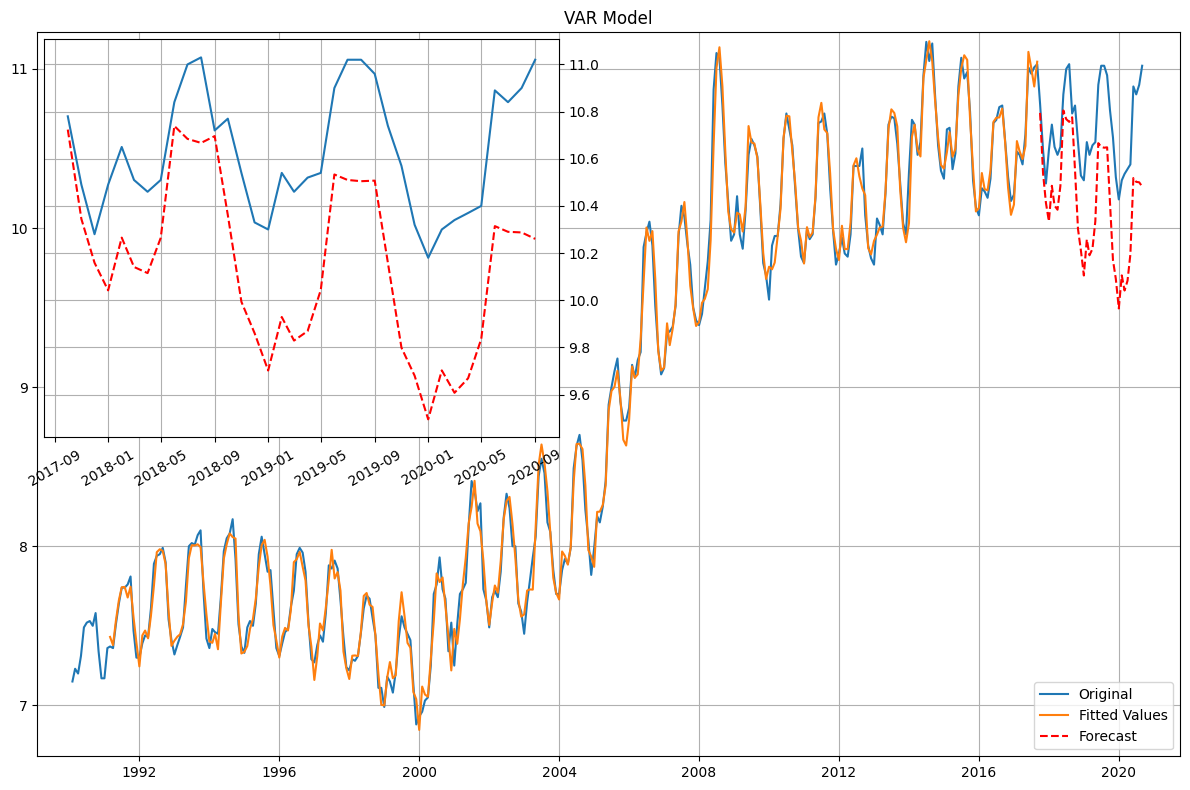

In [296]:
print('MAE: {:.3f}\nRMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], forecast_var.Price),
    root_mean_squared_error(ytest[:forecast_length], forecast_var.Price)
))

# Plot
fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(pd.concat([ytrain, ytest[:forecast_length]]), label='Original')
ax.plot(model_var_fit.fittedvalues[:].Price, label='Fitted Values')
ax.plot(forecast_var.Price, c='r', ls='--', label='Forecast')
ax.grid(True)
ax.legend(loc='lower right')
inset = inset_axes(ax, width="45%", height="55%", loc=2)
inset.plot(ytest[:forecast_length])
inset.plot(forecast_var.Price, c='r', ls='--')
inset.grid(visible=True)
inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
inset.set_xticklabels(labels=inset.get_xticklabels(), rotation=30)
ax.set_xlim(
    datetime.date(train.index[0].year-1,train.index[0].month,1),
    datetime.date(test.index[forecast_length].year+1,test.index[forecast_length].month, 1)
)
ax.set_ylim(ytrain.min()-0.2, ytest[:forecast_length].max()+0.2)
ax.set_title('VAR Model')
plt.tight_layout()
plt.savefig('./figures/var')
plt.show()

### __FB Prophet__

18:50:33 - cmdstanpy - INFO - Chain [1] start processing
18:50:34 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 640x480 with 0 Axes>

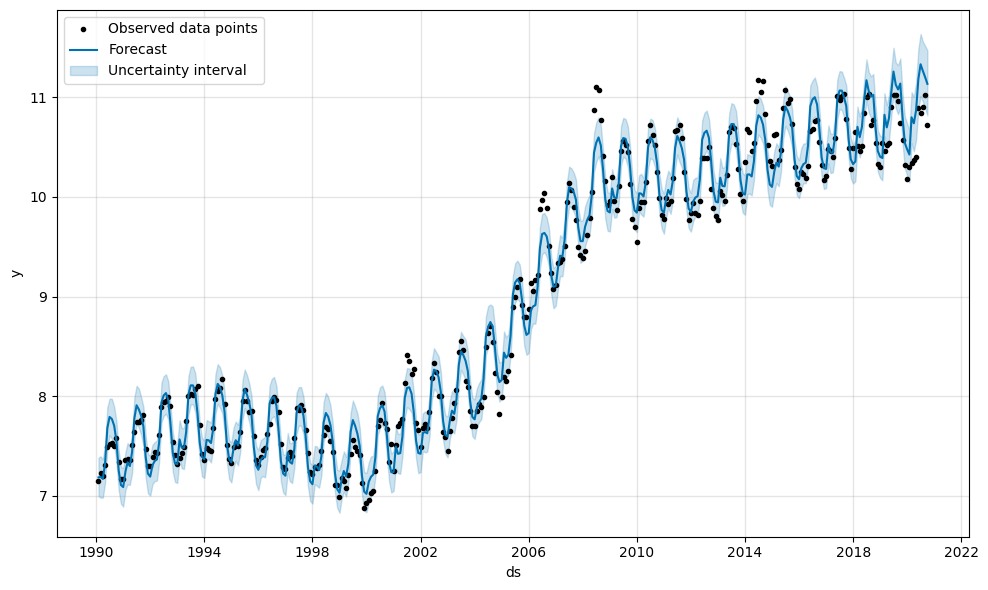

In [277]:
from prophet import Prophet

# New df specifically for FB Prophet
dfproph = pd.DataFrame()
dfproph['ds'] = train.index
dfproph['y'] = train.Price.values

m = Prophet()
m.fit(dfproph)

future = m.make_future_dataframe(periods=forecast_length+1, freq='M')
pred_fb = m.predict(future)

plt.figure()
m.plot(fcst=pred_fb, include_legend=True)
plt.scatter(ytest[:forecast_length+1].index, ytest[:forecast_length+1].values, c='k', marker='.')
plt.show()

In [278]:
pred_fb

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1990-02-01,7.313971,6.997900,7.385228,7.313971,7.313971,-0.128251,-0.128251,-0.128251,-0.128251,-0.128251,-0.128251,0.0,0.0,0.0,7.185719
1,1990-03-01,7.322619,6.983124,7.396801,7.322619,7.322619,-0.132631,-0.132631,-0.132631,-0.132631,-0.132631,-0.132631,0.0,0.0,0.0,7.189988
2,1990-04-01,7.332194,6.982598,7.366938,7.332194,7.332194,-0.160712,-0.160712,-0.160712,-0.160712,-0.160712,-0.160712,0.0,0.0,0.0,7.171482
3,1990-05-01,7.341460,7.130229,7.510783,7.341460,7.341460,-0.017633,-0.017633,-0.017633,-0.017633,-0.017633,-0.017633,0.0,0.0,0.0,7.323827
4,1990-06-01,7.351035,7.477715,7.890267,7.351035,7.351035,0.330349,0.330349,0.330349,0.330349,0.330349,0.330349,0.0,0.0,0.0,7.681384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,2020-05-31,10.882225,10.881172,11.482925,10.664844,11.105642,0.297866,0.297866,0.297866,0.297866,0.297866,0.297866,0.0,0.0,0.0,11.180091
365,2020-06-30,10.889117,11.010046,11.633280,10.660909,11.127270,0.440130,0.440130,0.440130,0.440130,0.440130,0.440130,0.0,0.0,0.0,11.329247
366,2020-07-31,10.896238,10.956096,11.554922,10.652206,11.147068,0.365923,0.365923,0.365923,0.365923,0.365923,0.365923,0.0,0.0,0.0,11.262161
367,2020-08-31,10.903359,10.881079,11.512910,10.647590,11.161674,0.295483,0.295483,0.295483,0.295483,0.295483,0.295483,0.0,0.0,0.0,11.198842


In [279]:
pred_fb.set_index('ds', inplace=True)

MAE: 0.230
RMSE: 0.291


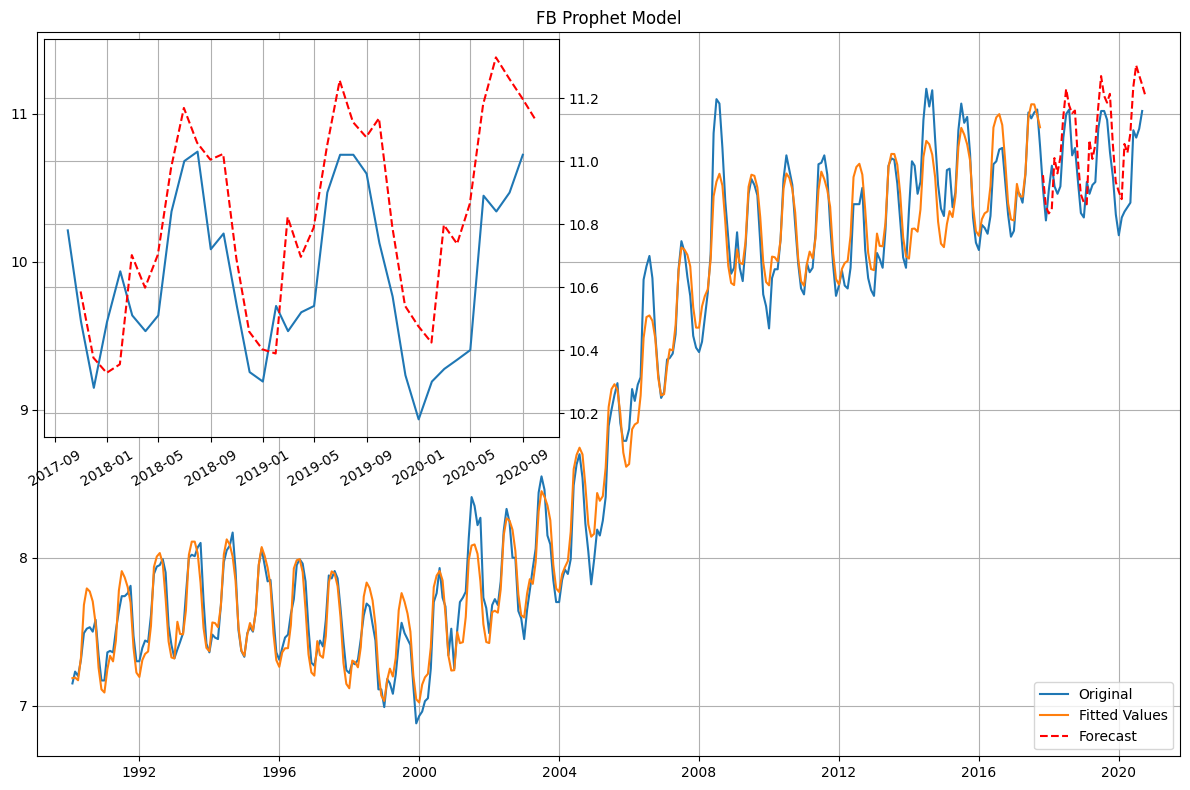

In [298]:
print('MAE: {:.3f}\nRMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], pred_fb.yhat[splitdate:]),
    root_mean_squared_error(ytest[:forecast_length], pred_fb.yhat[splitdate:])
))

# Plot
fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(pd.concat([ytrain, ytest[:forecast_length]]), label='Original')
ax.plot(pred_fb.yhat[:splitdate], label='Fitted Values')
ax.plot(pred_fb.yhat[splitdate:], c='r', ls='--', label='Forecast')
ax.grid(True)
ax.legend(loc='lower right')
# ins = ax.inset_axes([0, 0.5, 0.2,0.2])
inset = inset_axes(ax, width="45%", height="55%", loc=2)
inset.plot(ytest[:forecast_length])
inset.plot(pred_fb.yhat[splitdate:], c='r', ls='--')
inset.grid(visible=True)
inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
inset.set_xticklabels(labels=inset.get_xticklabels(), rotation=30)
ax.set_xlim(
    datetime.date(train.index[0].year-1,train.index[0].month,1),
    datetime.date(test.index[forecast_length].year+1,test.index[forecast_length].month, 1)
)
ax.set_title('FB Prophet Model')
plt.tight_layout()
plt.savefig('./figures/fbprophet')
plt.show()

FB Prophet model does very well with data, achieving MSE of 0.08.

### __Exponential Smoothing__

In [281]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [282]:
# Define the Holt-Winters model
model_es = ExponentialSmoothing(ytrain, 
                             trend="add",  # Linear trend
                             seasonal="add",  # Seasonal component
                             seasonal_periods=12)  # 12 months for yearly seasonality

# Fit the model
model_es_fit = model_es.fit()

# Forecast the next test period
forecast_es = model_es_fit.forecast(steps=forecast_length)

In [283]:
print(model_es_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  332
Model:             ExponentialSmoothing   SSE                              3.526
Optimized:                         True   AIC                          -1476.901
Trend:                         Additive   BIC                          -1416.019
Seasonal:                      Additive   AICC                         -1474.716
Seasonal Periods:                    12   Date:                 Mon, 17 Mar 2025
Box-Cox:                          False   Time:                         18:50:44
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.7986300                alpha                 True
smoothing_trend          

MAE: 0.219
RMSE: 0.271


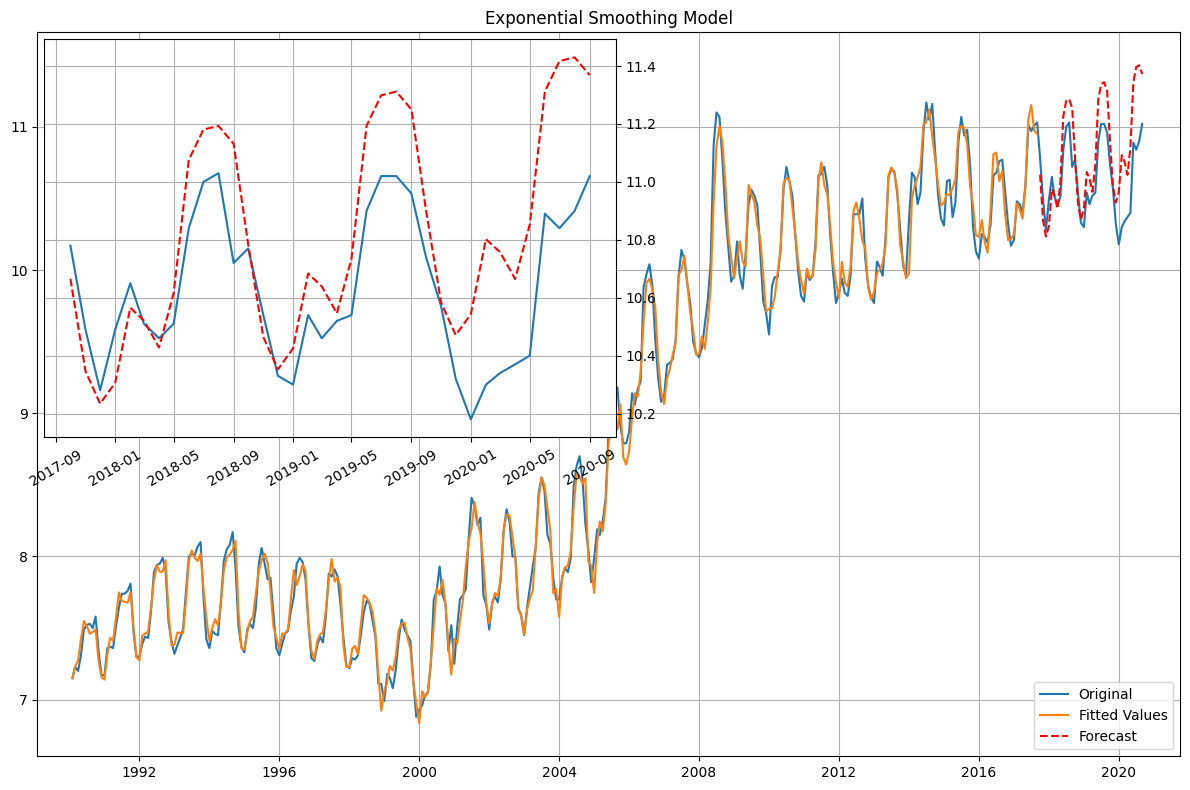

In [299]:
print('MAE: {:.3f}\nRMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], forecast_es),
    root_mean_squared_error(ytest[:forecast_length], forecast_es)
))

# Plot
fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(pd.concat([ytrain, ytest[:forecast_length]]), label='Original')
ax.plot(model_es_fit.fittedvalues, label='Fitted Values')
ax.plot(forecast_es, c='r', ls='--', label='Forecast')
ax.grid(True)
ax.legend(loc='lower right')
inset = inset_axes(ax, width="50%", height="55%", loc=2)
inset.plot(ytest[:forecast_length])
inset.plot(forecast_es, c='r', ls='--')
inset.grid(visible=True)
inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
inset.set_xticklabels(labels=inset.get_xticklabels(), rotation=30)
ax.set_xlim(
    datetime.date(train.index[0].year-1,train.index[0].month,1),
    datetime.date(test.index[forecast_length].year+1,test.index[forecast_length].month, 1)
)
ax.set_title('Exponential Smoothing Model')
plt.tight_layout()
plt.savefig('./figures/expsmoothing')
plt.show()

Exponential Smoothing model works great.

In [285]:
# One step ahead cross validation
def one_step_ahead_cv(model_class, model_params, y, train_size=split):
    """
    Perform rolling-origin one-step-ahead cross-validation.
    
    Parameters:
        model_class: The forecasting model class (e.g., ARIMA, ExponentialSmoothing).
        model_params: Dictionary of parameters for the model.
        y: Time series data.
        train_size: Proportion of data to use for initial training.

    Returns:
        y_test: Actual test values.
        predictions: Model forecasts.
    """
    train_len = int(len(y) * train_size)
    train, test = y[:train_len], y[train_len:]
    
    history = list(train)  # Start with initial training set
    predictions = []
    
    for t in range(len(test)):
        # Fit model on the current history
        model = model_class(history, **model_params).fit()
        
        # Predict the next step
        forecast = model.forecast(steps=1)[0]
        predictions.append(forecast)
        
        # Add true value to training set (walk-forward validation)
        history.append(test.iloc[t])

    return test, predictions

In [286]:
datetime.date(int(splitdate.year+forecast_length/12), splitdate.month,1)

datetime.date(2020, 10, 1)

In [287]:
# Define ARIMA model parameters
arima_params = {"order": (2,1,2)}

# Run one-step-ahead validation
y_test, arima_preds = one_step_ahead_cv(ARIMA, arima_params, df.Price)

# Compute performance
mae = mean_absolute_error(y_test, arima_preds)
rmse = np.sqrt(mean_squared_error(y_test, arima_preds))
print(f"ARIMA MAE: {mae:.4f}, RMSE: {rmse:.4f}")

ARIMA MAE: 0.2037, RMSE: 0.2719


In [288]:
# Define Exponential Smoothing parameters
hw_params = {"trend": "add", "seasonal": "add", "seasonal_periods": 12}

# Run cross-validation
y_test, hw_preds = one_step_ahead_cv(ExponentialSmoothing, hw_params, df.Price)
# [:datetime.date(int(splitdate.year+forecast_length/12), splitdate.month,1)]

# Evaluate
mae = mean_absolute_error(y_test, hw_preds)
rmse = np.sqrt(mean_squared_error(y_test, hw_preds))
print(f"Holt-Winters MAE: {mae:.4f}, RMSE: {rmse:.4f}")

Holt-Winters MAE: 0.1343, RMSE: 0.1859


In [289]:

def one_step_ahead_cv_var(df, train_size=split, lags=2):
    train_len = int(len(df) * train_size)
    train, test = df.iloc[:train_len], df.iloc[train_len:]

    history = train.copy()
    predictions = []

    for t in range(len(test)):
        model = VAR(history)
        model_fitted = model.fit(lags)
        forecast = model_fitted.forecast(history.values[-lags:], steps=1)
        predictions.append(forecast[0])

        # Add true values to history
        history = pd.concat([history, test.iloc[[t]]])

    return test, np.array(predictions)

# Apply to dataset
y_test, var_preds = one_step_ahead_cv_var(df[["Price", "Electric"]], lags=2)

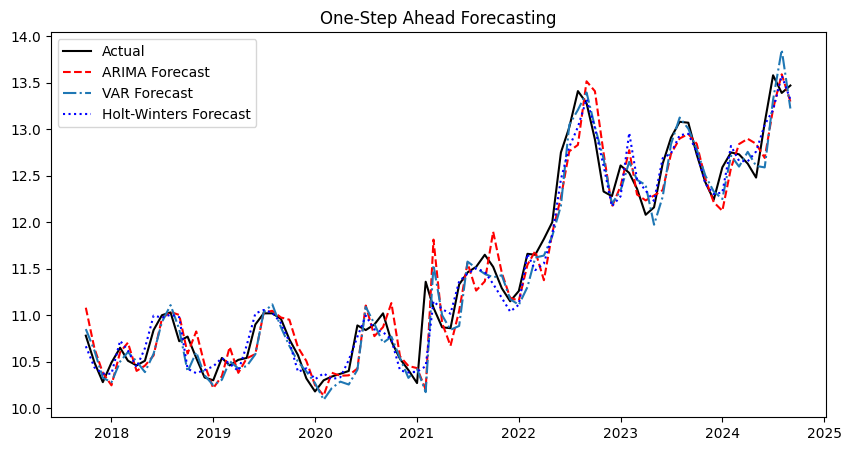

In [290]:
plt.figure(figsize=(10,5))
plt.plot(y_test.Price, label="Actual", color="black")
plt.plot(y_test.index, arima_preds, label="ARIMA Forecast", linestyle="dashed", color="red")
plt.plot(y_test.index, var_preds[:,0], ls='-.', label="VAR Forecast")
plt.plot(y_test.index, hw_preds, label="Holt-Winters Forecast", linestyle="dotted", color="blue")
plt.legend()
plt.title("One-Step Ahead Forecasting")
plt.show()

### __Summary__

#### Model Statistics
(For split size 0.7)

1: ARIMA(212)\
&emsp;This model did not have great prediction, capturing some seasonality but not trend. MAE: 0.382, RMSE: 0.438.

2: SARIMAX(302)x(202,12) exogenous = exogenous\
&emsp;This model had great prediction and is the second best performing model, MAE: 0.173, RMSE: 0.204.

3: SARIMAX(212)x(212,12) exogenous = exogenous\
&emsp;This model performed well, similar to above but MAE and RMSE slightly higher.

4: SARIMAX(202)x(101,12) exogenous = merge\
&emsp;This model performed okay, capturing seasonality but not quite trend. MAE: 0.380, MSE: 0.441.

5: VAR\
&emsp;This model performsvery well, only beating model 2 by 0.004 RMSE. MAE: 0.159, RMSE: 0.200.

6: Facebook Prophet\
&emsp;This model performs nicely, MAE: 0.202, MSE: 0.248.

7: Exponential Smoothing\
&emsp;This model does well, MAE: 0.2, MSE: 0.249.